- Requirements.txt should contain the following (other modules are included in the standard Python library):
    - requests
    - pandas
    - pytz

In [1]:
################################################################################
# make these imports into a set of requirements (see above)
################################################################################

import requests
import pandas as pd
from datetime import date, timedelta, datetime
import pytz
import json

In [2]:
# Coordinates for [location]: 
latitude = '55.951009'
longitude = '-3.100191'

# Set the start date to current date:
start_date = date.today()

In [3]:
################################################################################
# function to fetch sunrise and sunset data
################################################################################

def fetch_sunrise_sunset_data(date_str):
    url = f'https://api.sunrise-sunset.org/json?lat={latitude}&lng={longitude}&date={date_str}&formatted=0'
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching sunrise/sunset data: {response.status_code}")
        return None

################################################################################
# function to convert times to local
################################################################################

def convert_to_bst(time_str):
    gmt = pytz.timezone('GMT')
    bst = pytz.timezone('Europe/London')
    gmt_time = datetime.fromisoformat(time_str).replace(tzinfo=gmt)
    bst_time = gmt_time.astimezone(bst)
    return bst_time.strftime('%H:%M')

################################################################################
# use the functions to fetch times for one week
################################################################################

sun_data = []

for i in range(7):
    current_date = start_date + timedelta(days=i)
    date_str = current_date.isoformat()
    sun_info = fetch_sunrise_sunset_data(date_str)

    if sun_info:
        sun_data.append({
            'date': date_str,
            'sunrise': convert_to_bst(sun_info['results']['sunrise']),
            'sunset': convert_to_bst(sun_info['results']['sunset'])
        })

In [5]:
################################################################################
# put the data in a dataframe
################################################################################

df = pd.DataFrame(sun_data)


In [6]:
################################################################################
# use the date column as the index
################################################################################

df.set_index('date', inplace=True)

SO FAR SO GOOD
---

- Add a Day Of The Week column
- Fetch the Tides webpage using Python's requests library.

- Parse the HTML: use Beautiful Soup to parse the HTML and find the table containing the tide data.

- Extract and structure the data: go through cell by cell to extract the tide data and put it into a structured format. This might involve creating a Pandas DataFrame, or perhaps a more specialized data structure that's suited to your needs.

- Convert to the desired format: If necessary, you may need to convert the times to a different format, or perform other transformations on the data to prepare it for your analysis.

In [3]:
################################################################################
# get tide data
################################################################################

tide_api_key = '6b5b027a-289e-4ec2-b247-c03e71beea6e'

tide_url = f'https://www.worldtides.info/api/v3?extremes&lat={latitude}&lon={longitude}&days=7&date=today&key={tide_api_key}&datum=LAT'
tide_response = requests.get(tide_url)

if tide_response.status_code == 200:
    tide_data = tide_response.json()

else:
    print(f"Error fetching tide data: {tide_response.status_code}")

In [4]:
################################################################################
# Initialize the Tide, Time, Height columns in the dataframe
################################################################################

for i in range(1, 5):
    df[f'Tide{i}'] = None
    df[f'Time{i}'] = None
    df[f'Height{i}'] = None

################################################################################
# Process the tide data and store it in the DataFrame
################################################################################

for extreme in tide_data['extremes']:
    date_time = datetime.fromtimestamp(extreme['dt'])
    tide_type = extreme['type']
    
################################################################################
# Format the date and time as strings
################################################################################

    date_str = date_time.strftime('%Y-%m-%d')
    time_str = date_time.strftime('%H:%M')
    
################################################################################
# Check if the date exists in the DataFrame's index
################################################################################

    if date_str in df.index:

################################################################################
# Find the first available Extreme column with a None value and populate it with the tide event data
################################################################################

        for i in range(1, 5):
            if df.at[date_str, f'Tide{i}'] is None:
                df.at[date_str, f'Tide{i}'] = tide_type.capitalize()
                df.at[date_str, f'Time{i}'] = time_str
                break


In [5]:
################################################################################
# Weather - Make an API call to fetch the hourly temperature data
################################################################################

url = f'https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&hourly=temperature_2m,weathercode&timezone=GMT'
response = requests.get(url)

if response.status_code == 200:
    data = response.json()

    hourly_data = data['hourly']
    temperature_2m = hourly_data['temperature_2m']
    weathercode = hourly_data['weathercode']
    timestamps = hourly_data['time']

    daily_temperatures = {}
    for i, temp in enumerate(temperature_2m):
        dt = datetime.fromisoformat(timestamps[i])
        date_str = dt.strftime('%Y-%m-%d')
        hour = dt.hour

################################################################################
# Consider daytime hours between 6 AM and 6 PM
################################################################################

        if 6 <= hour < 18:
            if date_str not in daily_temperatures:
                daily_temperatures[date_str] = {'total_temp': 0, 'count': 0, 'weathercode': weathercode[i]}
            
            daily_temperatures[date_str]['total_temp'] += temp
            daily_temperatures[date_str]['count'] += 1

################################################################################
# Calculate the average daytime temperature
################################################################################

    for date_str in daily_temperatures:
        total_temp = daily_temperatures[date_str]['total_temp']
        count = daily_temperatures[date_str]['count']
        average_temp = total_temp / count
        daily_weathercode = daily_temperatures[date_str]['weathercode']
        
################################################################################
# print(f"{date_str}: {average_temp:.1f}°C, weathercode: {daily_weathercode}")
################################################################################

else:
    print(f"Error fetching weather data: {response.status_code}")


In [6]:
################################################################################
# Dataframe - Add new columns for average temperature and weathercode
################################################################################

df["average_temperature"] = None
df["weathercode"] = None

################################################################################
# Dataframe - Loop through daily_temperatures dictionary, update DataFrame
################################################################################

for date_str in daily_temperatures:
    total_temp = daily_temperatures[date_str]['total_temp']
    count = daily_temperatures[date_str]['count']
    average_temp = total_temp / count
    daily_weathercode = daily_temperatures[date_str]['weathercode']
    
################################################################################
# DataFrame - add Avg Temp and Weather data
################################################################################

    df.at[date_str, "average_temperature"] = round(average_temp, 1)
    df.at[date_str, "weathercode"] = daily_weathercode

In [7]:
################################################################################
# Weather - Create a dictionary to map weathercodes to descriptions
################################################################################

weathercode_descriptions = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Light drizzle",
    53: "Moderate drizzle",
    55: "Dense drizzle",
    56: "Light freezing drizzle",
    57: "Dense freezing drizzle",
    61: "Slight rain",
    63: "Moderate rain",
    65: "Heavy rain",
    66: "Light freezing rain",
    67: "Heavy freezing rain",
    71: "Slight snowfall",
    73: "Moderate snowfall",
    75: "Heavy snowfall",
    77: "Snow grains",
    80: "Slight rain showers",
    81: "Moderate rain showers",
    82: "Violent rain showers",
    85: "Slight snow showers",
    86: "Heavy snow showers",
    95: "Slight or moderate thunderstorm",
    96: "Thunderstorm with slight hail",
    99: "Thunderstorm with heavy hail",
}

################################################################################
# Dataframe - Update Weathercode column with descriptions
################################################################################

df["weathercode"] = df["weathercode"].apply(lambda x: weathercode_descriptions.get(x, "Unknown"))

In [8]:
################################################################################
# Step 1: Initialize the tide_events_by_date dictionary
################################################################################

tide_events_by_date = {date_str: [] for date_str in df.index}

################################################################################
# Step 2: Process the tide data and store it in the tide_events_by_date dictionary
################################################################################

for extreme in tide_data["extremes"]:
    date_time = datetime.fromtimestamp(extreme["dt"])
    tide_type = extreme["type"]
    tide_height = extreme["height"]
    
################################################################################
# Format the date and time as strings
################################################################################

    date_str = date_time.strftime("%Y-%m-%d")
    time_str = date_time.strftime("%H:%M")
    
################################################################################
# Check if the date is in the tide_events_by_date dictionary
################################################################################

    if date_str in tide_events_by_date:

################################################################################
# Append the tide event to the list of tide events for the corresponding date
################################################################################

        tide_events_by_date[date_str].append((tide_type, time_str, tide_height))

################################################################################
# Step 3: Update the DataFrame to include the tide heights
################################################################################

for index, row in df.iterrows():
    date_str = index
    tide_events = tide_events_by_date[date_str]
    
    for i, (tide_type, time_str, tide_height) in enumerate(tide_events):
        df.at[index, f"Tide{i+1}"] = f"{tide_type} {tide_height:.2f}"
        df.at[index, f"Time{i+1}"] = time_str

In [9]:
################################################################################
# Step 1: Initialize the tide_events_by_date dictionary
################################################################################

tide_events_by_date = {date_str: [] for date_str in df.index}

################################################################################
# Step 2: Process the tide data and store it in the tide_events_by_date dictionary
################################################################################

for extreme in tide_data["extremes"]:
    date_time = datetime.fromtimestamp(extreme["dt"])
    tide_type = extreme["type"]
    tide_height = extreme["height"]
    
################################################################################
# Format the date and time as strings
################################################################################

    date_str = date_time.strftime("%Y-%m-%d")
    time_str = date_time.strftime("%H:%M")
    
################################################################################
# Check if the date is in the tide_events_by_date dictionary
################################################################################

    if date_str in tide_events_by_date:

################################################################################
# Append the tide event to the list of tide events for the corresponding date
################################################################################

        tide_events_by_date[date_str].append((tide_type, time_str, tide_height))

################################################################################
# Step 3: Update the DataFrame to include the tide heights
################################################################################

for index, row in df.iterrows():
    date_str = index
    tide_events = tide_events_by_date[date_str]
    
    for i, (tide_type, time_str, tide_height) in enumerate(tide_events):
        df.at[index, f"Tide{i+1}"] = tide_type
        df.at[index, f"Time{i+1}"] = time_str
        df.at[index, f"Height{i+1}"] = tide_height

################################################################################
# Print the updated DataFrame
################################################################################

display(df)


,sunrise,sunset,Tide1,Time1,Height1,Tide2,Time2,Height2,Tide3,Time3,Height3,Tide4,Time4,Height4,average_temperature,weathercode
date,,,,,,,,,,,,,,,,
2023-05-24,04:42,21:36,High,06:13,4.988,Low,11:52,1.441,High,18:50,4.785,Low,23:52,1.941,15.3,Overcast
2023-05-25,04:40,21:37,High,06:56,4.786,Low,12:31,1.681,High,19:40,4.591,None,None,None,13.1,Overcast
2023-05-26,04:39,21:39,Low,00:30,2.185,High,07:43,4.599,Low,13:20,1.918,High,20:32,4.438,14.8,Partly cloudy
2023-05-27,04:38,21:40,Low,01:18,2.417,High,08:36,4.455,Low,14:50,2.091,High,21:28,4.355,15.0,Partly cloudy
2023-05-28,04:36,21:42,Low,02:28,2.584,High,09:35,4.385,Low,16:29,2.052,High,22:28,4.368,12.0,Mainly clear
2023-05-29,04:35,21:44,Low,04:43,2.529,High,10:38,4.42,Low,17:29,1.886,High,23:27,4.486,12.0,Partly cloudy
2023-05-30,04:34,21:45,Low,05:44,2.313,High,11:38,4.559,Low,18:17,1.683,None,None,None,13.1,Partly cloudy


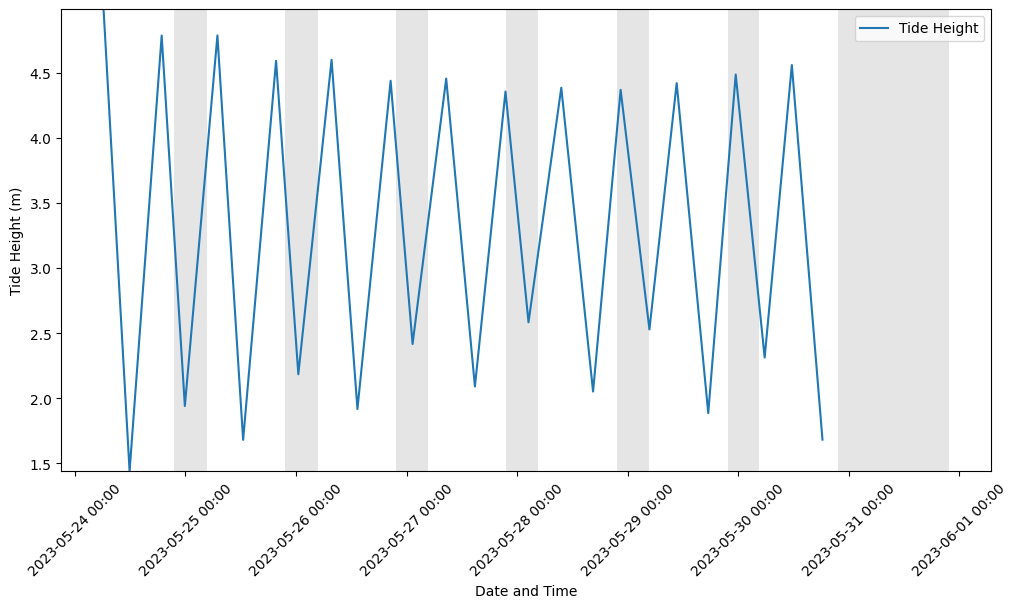

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))

all_heights = []
all_date_times = []

################################################################################
# Iterate through each tide event
################################################################################

for i in range(1, 5):

################################################################################
# Extract the tide heights and times
################################################################################

    heights = df[f"Height{i}"].dropna()
    times = df[f"Time{i}"].dropna().apply(lambda x: datetime.strptime(x, "%H:%M"))

################################################################################
# Combine the date and time information
################################################################################

    date_times = [datetime.combine(datetime.strptime(date, "%Y-%m-%d").date(), time.time()) for date, time in zip(heights.index, times)]

    all_heights.extend(heights)
    all_date_times.extend(date_times)

################################################################################
# Sort date_times and heights together based on the date_times
################################################################################

sorted_data = sorted(zip(all_date_times, all_heights))
sorted_date_times, sorted_heights = zip(*sorted_data)

################################################################################
# Plot the tide heights with lines connecting the points
################################################################################

ax.plot(sorted_date_times, sorted_heights, label="Tide Height")

################################################################################
# Add shaded regions for sunset and sunrise
################################################################################

for idx, row in df.iterrows():
    sunset_time = datetime.strptime(row['sunset'], "%H:%M").time()
    sunrise_time = datetime.strptime(row['sunrise'], "%H:%M").time()
    
    sunset_datetime = datetime.combine(datetime.strptime(idx, "%Y-%m-%d").date(), sunset_time)
    sunrise_datetime = datetime.combine(datetime.strptime(idx, "%Y-%m-%d").date(), sunrise_time)
    
    if idx != df.index[-1]:
        next_sunrise = datetime.combine(datetime.strptime(df.index[df.index.get_loc(idx) + 1], "%Y-%m-%d").date(), sunrise_time)
    else:
        next_sunrise = sunset_datetime + timedelta(days=1)

    ax.fill_between([sunset_datetime, next_sunrise], 0, ax.get_ylim()[1], facecolor='gray', alpha=0.2)

################################################################################
# Set the X-axis format and labels
################################################################################

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.xticks(rotation=45)

################################################################################
# Set the labels and legend
################################################################################

ax.set_xlabel("Date and Time")
ax.set_ylabel("Tide Height (m)")
ax.legend()

################################################################################
# Set the y-axis limits based on the smallest and largest height values
################################################################################

ax.set_ylim(min(all_heights), max(all_heights))

################################################################################
# Show the plot
################################################################################

plt.show()
